## Function for CPU Utilization Monitoring

In [1]:
import psutil
import time
import threading
import matplotlib.pyplot as plt

def monitor_task(task, *args, **kwargs):
    """
    Monitor CPU usage, memory usage, task duration, and time for a specific task.
    
    Parameters:
        task (function): The task function to be monitored.
        *args: Variable length argument list for the task function.
        **kwargs: Arbitrary keyword arguments for the task function.
    
    Returns:
        result: The result of the task function.
        metrics: A dictionary containing CPU usage, memory usage, task duration, and timestamps.
    """
    metrics = {
        "cpu_usage": [],
        "memory_usage": [],
        "timestamp": [],
        "total_duration": 0
    }
    
    start_time = time.time()
    task_done = threading.Event()
    
    def monitor():
        while not task_done.is_set():
            cpu_usage = psutil.cpu_percent(interval=1)
            memory_usage = psutil.virtual_memory().used / (1024 ** 3)  # Convert bytes to GB
            timestamp = time.time() - start_time
            
            metrics["cpu_usage"].append(cpu_usage)
            metrics["memory_usage"].append(memory_usage)
            metrics["timestamp"].append(timestamp)
    
    monitor_thread = threading.Thread(target=monitor)
    monitor_thread.start()
    
    try:
        result = task(*args, **kwargs)
    finally:
        task_done.set()
        monitor_thread.join()
    
    metrics["total_duration"] = time.time() - start_time
    return result, metrics


def plot_metrics(metrics, contributor):
    """
    Plot the monitored metrics in a 1x2 grid.
    
    Parameters:
        metrics (dict): The dictionary containing the metrics to be plotted.
        contributor (str): The name of the contributor.
    """
    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # Plot CPU Usage
    sns.lineplot(ax=axs[0], x=metrics['timestamp'], y=metrics['cpu_usage'], label=f'CPU Usage for {contributor}')
    axs[0].set_xlabel('Time (s)')
    axs[0].set_ylabel('CPU Usage (%)')
    axs[0].set_title('CPU Usage Over Time')
    axs[0].legend(fontsize='small', loc='upper right')
    axs[0].grid(True)

    # Plot Memory Usage
    sns.lineplot(ax=axs[1], x=metrics['timestamp'], y=metrics['memory_usage'], label=f'Memory Usage for {contributor}', color='orange')
    axs[1].set_xlabel('Time (s)')
    axs[1].set_ylabel('Memory Usage (GB)')
    axs[1].set_title('Memory Usage Over Time')
    axs[1].legend(fontsize='small', loc='upper right')
    axs[1].grid(True)

    # Print Total Duration
    fig.suptitle(f'Metrics for {contributor} (Total Task Duration: {metrics["total_duration"]:.2f} seconds)', fontsize=14)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

#### Connecting to the Blockchain and loading Contract

In [2]:
import json
from web3 import Web3
import requests

# Connect to Ganache
ganache_url = "http://127.0.0.1:8545"
web3 = Web3(Web3.HTTPProvider(ganache_url))
web3.eth.defaultAccount = web3.eth.accounts[0]

In [3]:
# Load Contracts
def load_contract(abi_path, contract_address):
    with open(abi_path) as f:
        contract_abi = json.load(f)['abi']
    return web3.eth.contract(address=contract_address, abi=contract_abi)

local_model_registry_address = "0x5507E5510C3c871b834B34fb23F06524738301e1"
aggregated_model_registry_address = "0x55a88597dE33e391bC6516927B2BD7EADB5e4C15"
reputation_system_address = "0x3ECED2194f327C8D9A58C4824fD1e124241be6DC"
file_metadata_registry_address = "0x96B1A6e8802ed8C3FcE04837470281c60dDc7122"

local_model_registry = load_contract('Blockchain_final/build/contracts/LocalModelRegistry.json', local_model_registry_address)
aggregated_model_registry = load_contract('Blockchain_final/build/contracts/AggregatedModelRegistry.json', aggregated_model_registry_address)
reputation_system = load_contract('Blockchain_final/build/contracts/ReputationSystem.json', reputation_system_address)
file_metadata_registry = load_contract('Blockchain_final/build/contracts/FileMetadataRegistry.json', file_metadata_registry_address)

#### Connecting to the IPFS

In [4]:
# Pinata API credentials
PINATA_BASE_URL = "https://api.pinata.cloud/"
PINATA_API_KEY = '41447cb8e9c4ac5f0c37'
PINATA_SECRET_API_KEY = 'a5033aa1f0e41a6ddd151e479100548920780a21b9c0ad0e9d196d52c0676a44'
endpoint = "pinning/pinFileToIPFS"
headers = {
    "pinata_api_key": PINATA_API_KEY,
    "pinata_secret_api_key": PINATA_SECRET_API_KEY
}

In [5]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import gzip
from sklearn.metrics import mean_squared_error, mean_absolute_error

def upload_file_to_ipfs(filepath):
    """
    Uploads a file to the IPFS (InterPlanetary File System) via the Pinata API and returns the IPFS CID of the uploaded file.
    
    Parameters:
        filepath (str): The path to the file to be uploaded.
    
    Returns:
        str: The IPFS CID of the uploaded file.
    """
    with open(filepath, "rb") as f:
        response = requests.post(PINATA_BASE_URL + endpoint, files={"file": f}, headers=headers)
        return response.json()["IpfsHash"]

def register_local_model(ipfs_hash, contributor):
    """
    Registers a local machine learning model in a blockchain-based registry using its IPFS hash.
    
    Parameters:
        ipfs_hash (str): The IPFS hash of the model.
        contributor (str): The address of the contributor registering the model.
    """
    tx_hash = local_model_registry.functions.registerLocalModel(ipfs_hash, contributor).transact({'from': contributor})
    web3.eth.wait_for_transaction_receipt(tx_hash)
    print(f"Local model registered with IPFS hash: {ipfs_hash}")

def register_aggregated_model(ipfs_hash, version, last_local_model_id):
    """
    Registers an aggregated machine learning model in a blockchain-based registry using its IPFS hash.
    
    Parameters:
        ipfs_hash (str): The IPFS hash of the aggregated model.
        version (int): The version number of the aggregated model.
        last_local_model_id (int): The ID of the last local model used in aggregation.
    """
    tx_hash = aggregated_model_registry.functions.registerAggregatedModel(ipfs_hash, version, last_local_model_id).transact({'from': web3.eth.accounts[0]})
    web3.eth.wait_for_transaction_receipt(tx_hash)
    print(f"Aggregated model version {version} registered with IPFS hash: {ipfs_hash}")

def reward_contributor(contributor, points):
    """
    Rewards a contributor with a certain number of reputation points in a blockchain-based reputation system.
    
    Parameters:
        contributor (str): The address of the contributor to be rewarded.
        points (int): The number of reputation points to be awarded.
    """
    tx_hash = reputation_system.functions.rewardContributor(contributor, points).transact({'from': contributor})
    web3.eth.wait_for_transaction_receipt(tx_hash)
    print(f"Contributor {contributor} rewarded with {points} points")

def add_file_metadata(file_hash, name, description, tags, contributor):
    """
    Adds metadata for a file in a blockchain-based registry.
    
    Parameters:
        file_hash (str): The IPFS hash of the file.
        name (str): The name.
        description (str): A description of the file.
        tags (str): tag associated with the file.
        contributor (str): The address of the contributor adding the metadata.
    """
    tx_hash = file_metadata_registry.functions.addFileMetadata(file_hash, name, description, tags).transact({'from': contributor})
    web3.eth.wait_for_transaction_receipt(tx_hash)
    print(f"Metadata added for file hash: {file_hash}")

def search_files_by_tag(tag):
    """
    Searches for files in a blockchain-based registry by a specific tag.
    
    Parameters:
        tag (str): The tag to search for.
    
    Returns:
        list: A list of results, each containing the name, description, IPFS hash, and timestamp.
    """
    ipfs_hashes = file_metadata_registry.functions.searchFilesByTag(tag).call()
    results = []
    for ipfs_hash in ipfs_hashes:
        name, description, tags, timestamp = file_metadata_registry.functions.getFileMetadata(ipfs_hash).call()
        results.append([name, description, ipfs_hash, timestamp])
    return results

def demonstrate_integrity_check(contributor, ipfs_hash):
    """
    Demonstrates an integrity check by comparing the provided IPFS hash with the latest registered model hash for a contributor.
    
    Parameters:
        contributor (str): The address of the contributor.
        ipfs_hash (str): The IPFS hash to be checked.
    """
    latest_hash = local_model_registry.functions.getLatestModelHash(contributor).call()
    if latest_hash != ipfs_hash:
        print("Data integrity check failed: Hash mismatch detected!")
    else:
        print("Data integrity check passed: Hash matches the latest registered model.")

def extract_trees(model):
    """
    Extracts individual decision trees from a trained RandomForest model.
    
    Parameters:
        model (RandomForestRegressor): The trained RandomForest model.
    
    Returns:
        list: A list of individual decision trees.
    """
    return model.estimators_

def aggregate_trees(trees_list):
    """
    Aggregates decision trees from multiple RandomForest models into a single list.
    
    Parameters:
        trees_list (list): A list of lists of decision trees.
    
    Returns:
        list: A single aggregated list of decision trees.
    """
    aggregated_trees = []
    for trees in trees_list:
        aggregated_trees.extend(trees)
    return aggregated_trees

def retrieve_model_from_ipfs(ipfs_hash):
    """
    Retrieves a gzipped machine learning model from IPFS using its IPFS hash and decompresses it.
    
    Parameters:
        ipfs_hash (str): The IPFS hash of the model.
    
    Returns:
        model: The retrieved and decompressed machine learning model.
    """
    ipfs_base_url = "https://ipfs.io/ipfs/"
    file_url = ipfs_base_url + ipfs_hash
    response = requests.get(file_url)
    compressed_model_data = response.content
    
    # Decompress the model data
    model_data = gzip.decompress(compressed_model_data)
    
    # Deserialize the model
    model = pickle.loads(model_data)
    return model

def get_contributor_reward(contributor):
    """
    Retrieves the reputation points of a contributor from a blockchain-based reputation system.
    
    Parameters:
        contributor (str): The address of the contributor.
    
    Returns:
        int: The number of reputation points the contributor has.
    """
    points = reputation_system.functions.getReputation(contributor).call()
    print(f"Contributor {contributor} has {points} points")
    return points

def train_local_model(X, y):
    """
    Trains a local RandomForestRegressor model.
    
    Parameters:
        X (DataFrame): The feature matrix.
        y (Series): The target variable.
    
    Returns:
        RandomForestRegressor: The trained RandomForestRegressor model.
    """
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X, y)
    return model

def load_test_data():
    """
    Loads test data from a CSV file and splits it into feature matrix and target variable.
    
    Returns:
        tuple: The test feature matrix (X_test) and the test target variable (y_test).
    """
    data = pd.read_csv('TX1_5m_Preprocessed.csv')
    X = data.drop('Severity', axis=1)  
    y = data['Severity']

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_test, y_test

#Evaluate the model
def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mse)
   
    return mse, mae, rmse

#### Functions for Federated Learning

In [6]:
import pickle
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

def train_register_local_model(contributor, dataset_path, target_column, description):
    """
    Train a local machine learning model, upload it to IPFS, and register it in a blockchain-based registry.
    
    Parameters:
        contributor (str): The address of the contributor.
        dataset_path (str): The path to the dataset CSV file.
        target_column (str): The name of the target column in the dataset.
        description (str): A description for the model metadata.
    
    Returns:
        int: The ID of the registered local model.
    """
    # Load dataset
    data = pd.read_csv(dataset_path)

    # Preprocessing
    X = data.drop(target_column, axis=1)
    y = data[target_column]

    # Split the data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Train model
    model = train_local_model(X_train, y_train)
    
    # Save model with gzip compression
    model_path = f'model_{contributor}.pkl.gz'
    with gzip.open(model_path, 'wb') as f:
        pickle.dump(model, f)
        
    # Upload model to IPFS
    model_hash = upload_file_to_ipfs(model_path)
    
    # Register model on the blockchain
    register_local_model(model_hash, contributor)
    
    # Get local model count
    local_model_id = local_model_registry.functions.getLocalModelCount().call()
    
    # Add metadata
    add_file_metadata(model_hash, f"Local Model by {contributor}", description, 'Local Model', contributor)

    # Calculate MSE for the model
    preds = model.predict(X_test)
    mse = mean_squared_error(y_test, preds)
    print(f"Contributor {contributor} - Model MSE: {mse}")

    # Reward contributor
    reward_contributor(contributor, int(100 / mse))  # Reward inversely proportional to MSE

    return local_model_id, model_hash
    
def train_aggregate_models():
    """
    Train an aggregated machine learning model by combining decision trees from multiple local models,
    upload it to IPFS, and register it in a blockchain-based registry.
    
    Returns:
        None
    """
    # Retrieve last aggregated model information
    last_aggregated_model_id = aggregated_model_registry.functions.aggregatedModelCount().call()
    if last_aggregated_model_id > 0:
        last_local_model_id = aggregated_model_registry.functions.getLastLocalModelId(last_aggregated_model_id).call()
    else:
        last_local_model_id = 0

    # Retrieve new local models from IPFS
    models = []
    local_model_count = local_model_registry.functions.getLocalModelCount().call()
    for model_id in range(last_local_model_id + 1, local_model_count + 1):
        model_data = local_model_registry.functions.getLocalModel(model_id).call()
        ipfs_hash = model_data[0]
        model = retrieve_model_from_ipfs(ipfs_hash)
        models.append(model)

    # Extract trees from each model
    trees_list = [extract_trees(model) for model in models]

    # Aggregate trees from all models
    aggregated_trees = aggregate_trees(trees_list)

    # Create a new model with aggregated trees
    aggregated_model = RandomForestRegressor(n_estimators=len(aggregated_trees), random_state=42)
    aggregated_model.estimators_ = aggregated_trees
    aggregated_model.n_estimators = len(aggregated_trees)
    aggregated_model.n_outputs_ = models[0].n_outputs_
    aggregated_model.n_features_in_ = models[0].n_features_in_
    aggregated_model.feature_names_in_ = models[0].feature_names_in_

    # Make predictions on the test set with the aggregated model
    X_test, y_test = load_test_data()
    final_preds = aggregated_model.predict(X_test)

    # Calculate the Mean Squared Error
    mse = mean_squared_error(y_test, final_preds)
    print(f"Mean Squared Error after federated learning: {mse:.4f}")

    # Save model with gzip compression
    aggregated_model_path = 'aggregated_model.pkl.gz'
    with gzip.open(aggregated_model_path, 'wb') as f:
        pickle.dump(aggregated_model, f)
        
    # Upload aggregated model to IPFS
    aggregated_model_hash = upload_file_to_ipfs(aggregated_model_path)
    
    # Register aggregated model on the blockchain
    register_aggregated_model(aggregated_model_hash, last_aggregated_model_id + 1, local_model_count)
    
    # Add metadata
    add_file_metadata(aggregated_model_hash, "Aggregated Model", f"An aggregated model from federated learning with model id {last_aggregated_model_id+1}", "Aggregated model", web3.eth.accounts[0])

In [7]:
contributor_1 = web3.eth.accounts[1]
contributor_2 = web3.eth.accounts[2]
contributor_3 = web3.eth.accounts[3]
contributor_4 = web3.eth.accounts[4]

## Processing Four Contributors in Parallel for Federated Learning

In [8]:
import concurrent.futures
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

datasets = ['contributor_1_dataset.csv', 'contributor_2_dataset.csv', 'contributor_3_dataset.csv', 'contributor_4_dataset.csv']
contributors = [contributor_1, contributor_2, contributor_3, contributor_4]

# Function to monitor and train model
def monitor_and_train(contributor, dataset_path):
    """
    Monitor system metrics while training a local model for a contributor.

    Parameters:
        contributor (str): The address of the contributor.
        dataset_path (str): The path to the dataset CSV file.

    Returns:
        tuple: The result of the training and the collected metrics.
    """
    result, metrics = monitor_task(train_register_local_model, contributor, dataset_path, 'Severity', f'Trained using {dataset_path} dataset')
    return result, metrics

# Run training in parallel
with concurrent.futures.ThreadPoolExecutor() as executor:
    future_to_contributor = {executor.submit(monitor_and_train, contributors[i], datasets[i]): contributors[i] for i in range(len(contributors))}

results = {}
for future in concurrent.futures.as_completed(future_to_contributor):
    contributor = future_to_contributor[future]
    try:
        result, metrics = future.result()
        results[contributor] = (result, metrics)
    except Exception as exc:
        print(f'{contributor} generated an exception: {exc}')

Local model registered with IPFS hash: QmUhVVg5Nc98dr61S91Sn53yBGsKbmP7SgdoNcBSuKxx54
Metadata added for file hash: QmUhVVg5Nc98dr61S91Sn53yBGsKbmP7SgdoNcBSuKxx54
Contributor 0xd80Bc78d596dA19a1d920913Cb438Fc608bb9C45 - Model MSE: 0.3303927913434551
Contributor 0xd80Bc78d596dA19a1d920913Cb438Fc608bb9C45 rewarded with 302 points
Local model registered with IPFS hash: Qme2W2oGxADBHLbVLSqU1fmo5RFd2ja9rmzqKkZnBvasz3
Metadata added for file hash: Qme2W2oGxADBHLbVLSqU1fmo5RFd2ja9rmzqKkZnBvasz3
Contributor 0xc6e114d43678ca3023C0bB7Dbe4E903504bbD118 - Model MSE: 0.3328156893274312
Contributor 0xc6e114d43678ca3023C0bB7Dbe4E903504bbD118 rewarded with 300 points
Local model registered with IPFS hash: QmeGscsgYG7TqX7hWw3TtjYRAFFGRCaAw6w9barjEEpiSn
Metadata added for file hash: QmeGscsgYG7TqX7hWw3TtjYRAFFGRCaAw6w9barjEEpiSn
Contributor 0xbC38e977741181F44b520193eeB88eE6b02848B2 - Model MSE: 0.3069891220022816
Contributor 0xbC38e977741181F44b520193eeB88eE6b02848B2 rewarded with 325 points
Local mode

Data integrity check passed: Hash matches the latest registered model.
Result for 0xbC38e977741181F44b520193eeB88eE6b02848B2: 3, Duration: 1215.6825647354126s


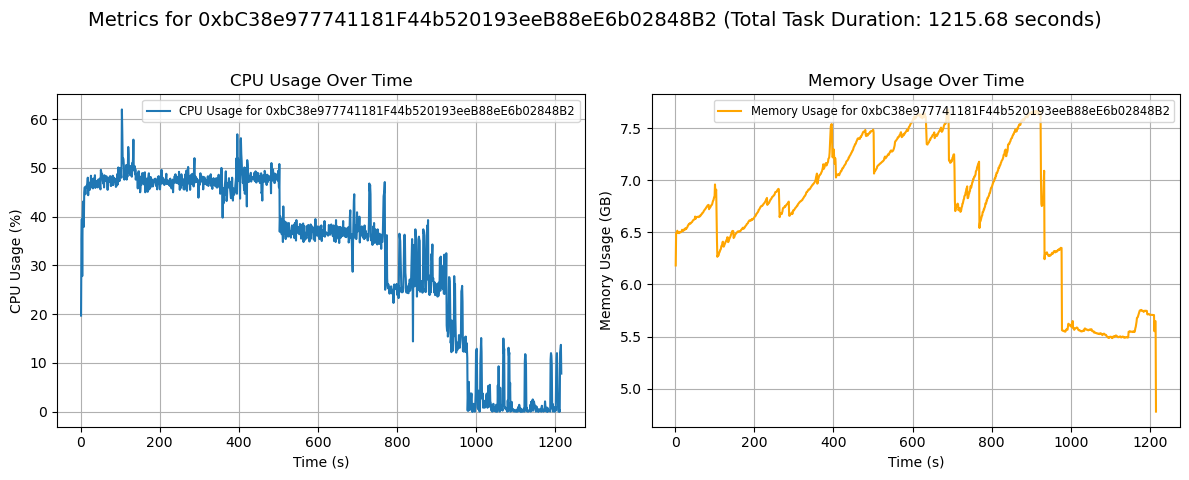

Data integrity check passed: Hash matches the latest registered model.
Result for 0xc6e114d43678ca3023C0bB7Dbe4E903504bbD118: 2, Duration: 934.8211405277252s


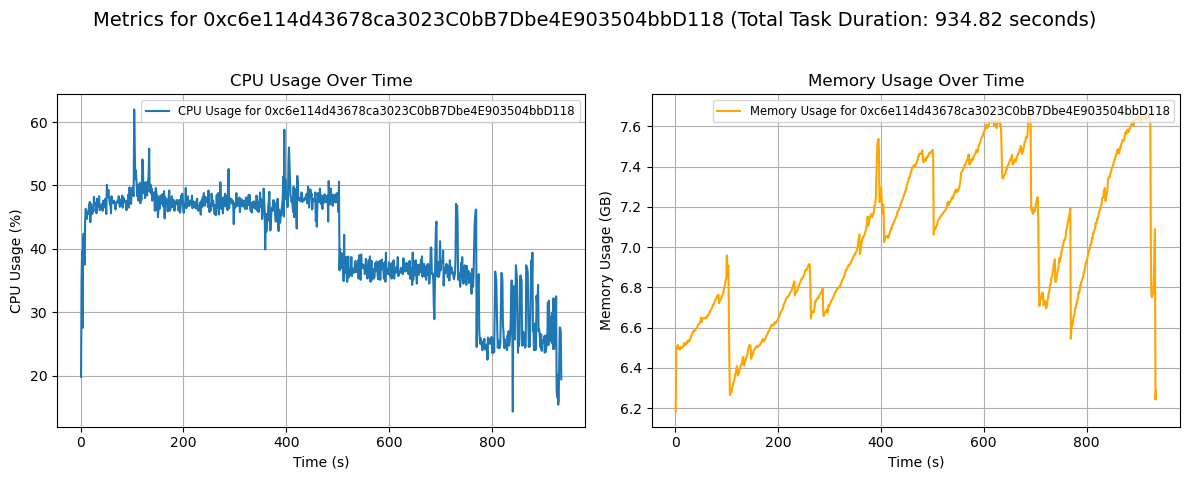

Data integrity check passed: Hash matches the latest registered model.
Result for 0xd80Bc78d596dA19a1d920913Cb438Fc608bb9C45: 1, Duration: 692.0561468601227s


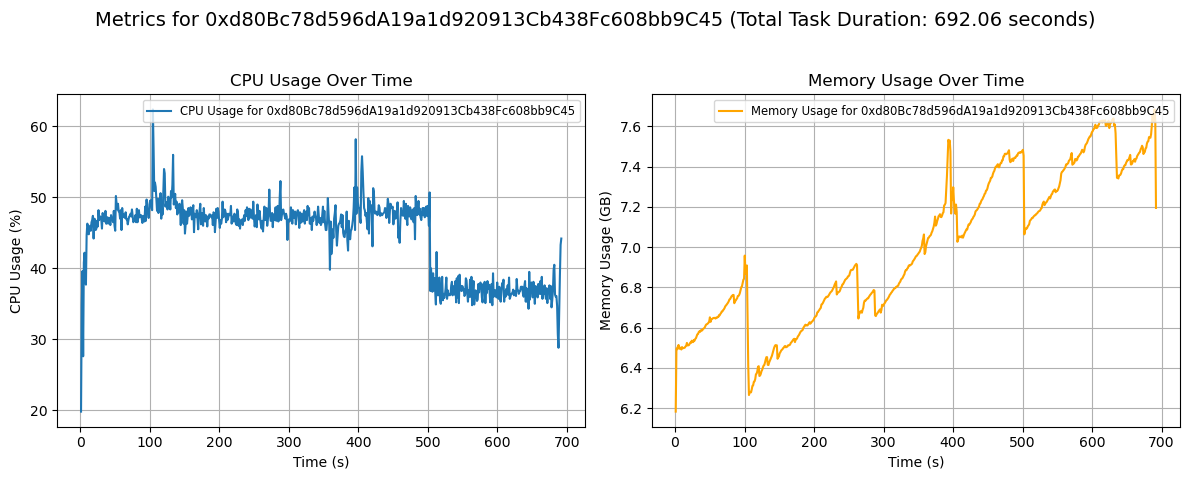

Data integrity check passed: Hash matches the latest registered model.
Result for 0x70E036734349E37e44a8519abbA637146e62CEe7: 4, Duration: 1289.9645223617554s


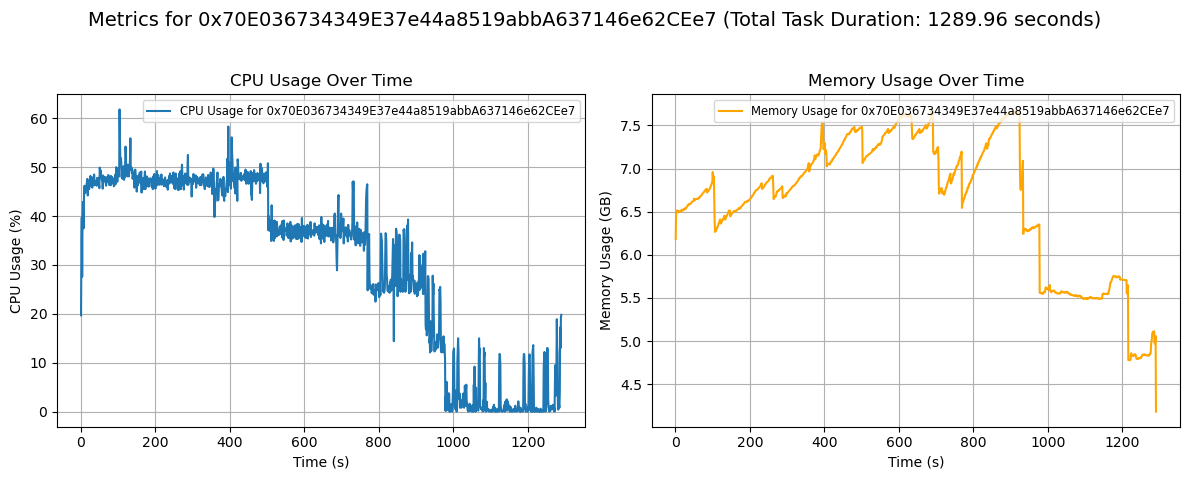

In [9]:
# Plot results for each contributor
for contributor, (result, metrics) in results.items():
    # Demonstrate integrity check
    demonstrate_integrity_check(contributor, result[1])
    print(f"Result for {contributor}: {result[0]}, Duration: {metrics['total_duration']}s")
    
    # Plot metrics using the plot_metrics function
    plot_metrics(metrics, contributor)

## Aggregating Local Models to Create an Aggregate Model

In [10]:
_, metrics = monitor_task(train_aggregate_models)

Mean Squared Error after federated learning: 0.4162
Aggregated model version 1 registered with IPFS hash: QmZKr61tYJhwJsexz3MdavAmDHAyq3SQCEo82X7kL9WyFa
Metadata added for file hash: QmZKr61tYJhwJsexz3MdavAmDHAyq3SQCEo82X7kL9WyFa


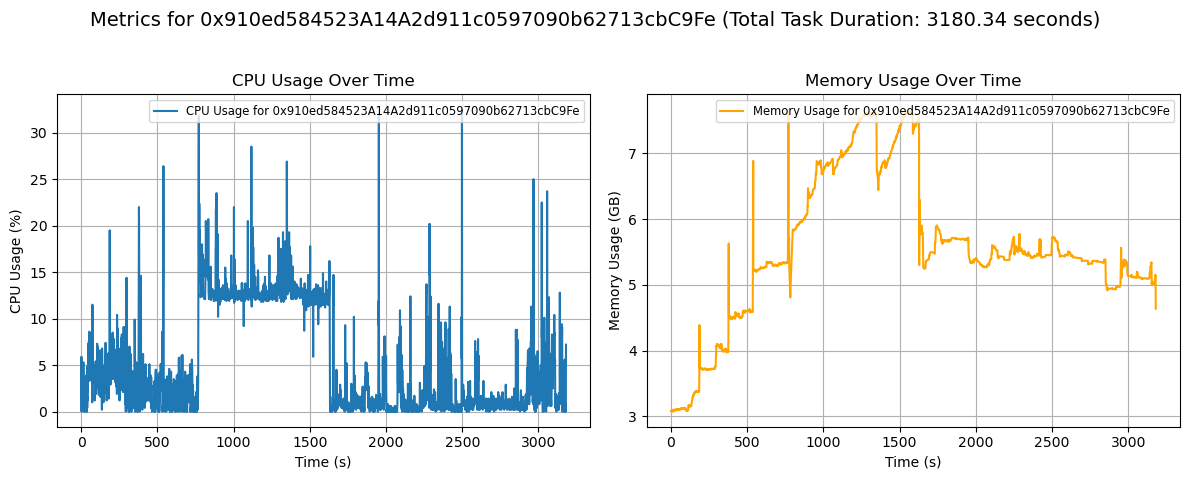

In [13]:
plot_metrics(metrics, web3.eth.accounts[0])

#### Retrieving the Metadata using tag from blockchain

In [14]:
from datetime import datetime
import pytz

# Example usage of search_files_by_tag function
tag = "Local Model"
files_metadata = search_files_by_tag(tag)

# Define local timezone
local_timezone = pytz.timezone('Europe/London')

converted_metadata = []

for metadata in files_metadata:
    timestamp = int(metadata[3])
    
    date_time_utc = datetime.utcfromtimestamp(timestamp)
    
    date_time_local = date_time_utc.replace(tzinfo=pytz.UTC).astimezone(local_timezone)

    date_time_str = date_time_local.strftime('%Y-%m-%d %H:%M:%S %Z')
    
    converted_metadata.append([metadata[0], metadata[1], metadata[2], date_time_str])

# Create a DataFrame from the converted metadata
df = pd.DataFrame(converted_metadata, columns=['Name', 'Description', 'IPFS CID', 'Timestamp'])

# Display the DataFrame
display(df)

,Name,Description,IPFS CID,Timestamp
0,Local Model by 0xd80Bc78d596dA19a1d920913Cb438...,Trained using contributor_4_dataset.csv dataset,QmUhVVg5Nc98dr61S91Sn53yBGsKbmP7SgdoNcBSuKxx54,2024-08-10 12:13:03 BST
1,Local Model by 0xc6e114d43678ca3023C0bB7Dbe4E9...,Trained using contributor_3_dataset.csv dataset,Qme2W2oGxADBHLbVLSqU1fmo5RFd2ja9rmzqKkZnBvasz3,2024-08-10 12:17:03 BST
2,Local Model by 0xbC38e977741181F44b520193eeB88...,Trained using contributor_1_dataset.csv dataset,QmeGscsgYG7TqX7hWw3TtjYRAFFGRCaAw6w9barjEEpiSn,2024-08-10 12:21:45 BST
3,Local Model by 0x70E036734349E37e44a8519abbA63...,Trained using contributor_2_dataset.csv dataset,QmUvqzerqGqhXesfqvCs91jo1kBifnxRrT8VZjYuLWp2h2,2024-08-10 12:22:59 BST


In [15]:
# Example usage of search_files_by_tag function
tag = "Aggregated model"
files_metadata = search_files_by_tag(tag)

# Define local timezone
local_timezone = pytz.timezone('Europe/London')

converted_metadata = []

for metadata in files_metadata:
    timestamp = int(metadata[3])
    
    date_time_utc = datetime.utcfromtimestamp(timestamp)
    
    date_time_local = date_time_utc.replace(tzinfo=pytz.UTC).astimezone(local_timezone)
    
    date_time_str = date_time_local.strftime('%Y-%m-%d %H:%M:%S %Z')
    
    converted_metadata.append([metadata[0], metadata[1], metadata[2], date_time_str])

# Create a DataFrame from the converted metadata
df = pd.DataFrame(converted_metadata, columns=['Name', 'Description', 'IPFS CID', 'Timestamp'])

# Display the DataFrame
display(df)

,Name,Description,IPFS CID,Timestamp
0,Aggregated Model,An aggregated model from federated learning wi...,QmZKr61tYJhwJsexz3MdavAmDHAyq3SQCEo82X7kL9WyFa,2024-08-10 13:48:55 BST


#### Checking each contributors total rewards

In [18]:
# Example usage of get_contirbutor_reward function
for contributor in contributors:
    get_contributor_reward(contributor)

Contributor 0xbC38e977741181F44b520193eeB88eE6b02848B2 has 325 points
Contributor 0x70E036734349E37e44a8519abbA637146e62CEe7 has 290 points
Contributor 0xc6e114d43678ca3023C0bB7Dbe4E903504bbD118 has 300 points
Contributor 0xd80Bc78d596dA19a1d920913Cb438Fc608bb9C45 has 302 points


In [19]:
aggregated_model_metadata = search_files_by_tag("Aggregated model")

In [20]:
aggregated_model_cid = aggregated_model_metadata[-1][2]

In [21]:
aggregated_model = retrieve_model_from_ipfs(aggregated_model_cid)

In [22]:
X_test, y_test = load_test_data()

In [23]:
# Evaluate the model
mse, mae, rmse= evaluate_model(aggregated_model, X_test, y_test)

# Print the evaluation metrics
print(f"MSE: {mse}")
print(f"MAE: {mae}")
print(f"RMSE: {rmse}")

MSE: 0.4162294833498777
MAE: 0.5187263760817546
RMSE: 0.6451584947513888
